In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from imblearn.over_sampling import SMOTE


In [2]:
data = pd.read_excel("/content/GP2F.xlsx")

In [4]:
colorPalette= ['#78a798', '#c6c6c6','#d68889','#6F8FAF']
# 0 glyco 1 micro 2 ceph

In [5]:
data['Antibiotic_Family'].value_counts()

Antibiotic_Family
Glycopeptides       96205
Macrolides          23847
Cephalosporins      17392
Oxazolidinones        679
Penicillins           488
Anticoagulants        481
Immunoglobulins       159
Fluoroquinolones       76
Aminoglycosides        70
Lincosamides           25
Name: count, dtype: int64

In [6]:
data = pd.DataFrame(data)
# List of values to remove from the DataFrame
values_to_remove = ['Lincosamides', 'Aminoglycosides', 'Fluoroquinolones', 'Immunoglobulins']
data = data[~data.isin(values_to_remove).any(axis=1)]
data['Antibiotic_Family'].value_counts()

Antibiotic_Family
Glycopeptides     96205
Macrolides        23847
Cephalosporins    17392
Oxazolidinones      679
Penicillins         488
Anticoagulants      481
Name: count, dtype: int64

visualize antibiotics count

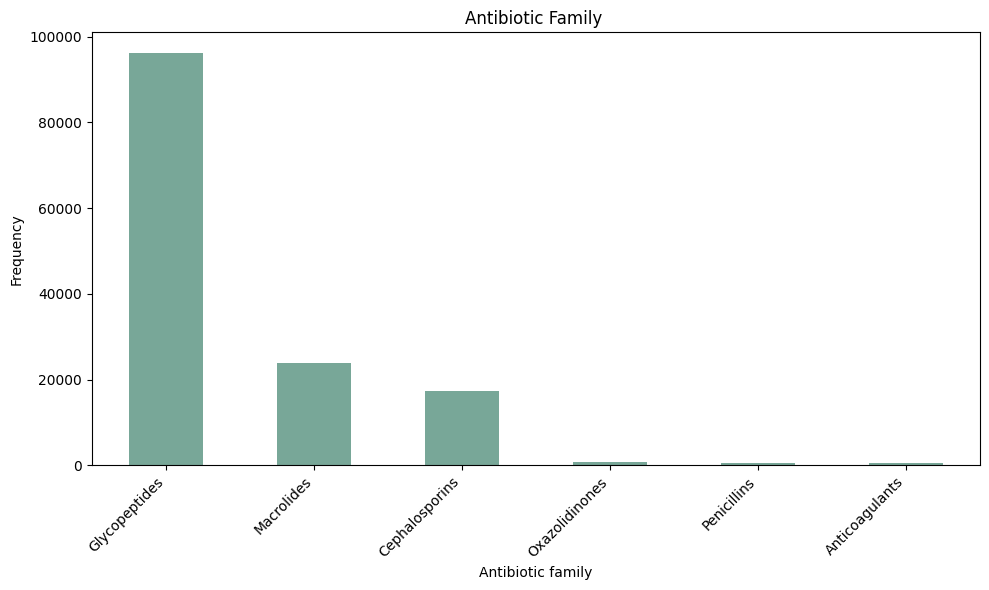

In [7]:
family_counts = data['Antibiotic_Family'].value_counts()
plt.figure(figsize=(10, 6))
family_counts.plot(kind='bar', color=colorPalette[0])
plt.title('Antibiotic Family ')
plt.xlabel('Antibiotic family')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [8]:
data['Bacteria'].value_counts()

Bacteria
Escherichia coli                                   39555
Klebsiella pneumoniae                              28477
Pseudomonas aeruginosa                             13626
Staphylococcus (coagulase-negative)                12564
Acinetobacter baumannii                            10429
Enterobacter cloacae                               10406
Staphylococcus aureus                              10168
Serratia marcescens                                 2468
Proteus mirabilis                                   2008
Enterococcus spp.                                   1601
Enterococcus faecalis                                942
Citrobacter freundii                                 899
Klebsiella oxytoca                                   692
Proteus spp.                                         617
Streptococcus spp. (Group Viridans α-hemolysis)      590
Streptococcus agalactiae (Group B β-hemolysis)       562
Klebsiella aerogenes                                 553
Morganella morganii   

# **LOGISTIC REGRESSION**

In [9]:
data=data.drop(['End date',"StartDate",'DiagnosisDateTime','PatientID','Hospital','City','AdmissionPeriod','Prescription','TreatmentTime','Antibiotics','InsuranceType'],axis=1)

# **Escherichia coli**

In [10]:
Eco= data[data['Bacteria'] == 'Escherichia coli']
df = pd.DataFrame(Eco)
df = df.applymap(str)


anything under 250 drop

In [11]:
Eco.Antibiotic_Family.value_counts()

Antibiotic_Family
Glycopeptides     21640
Macrolides        11201
Cephalosporins     6408
Anticoagulants      213
Penicillins          48
Oxazolidinones       45
Name: count, dtype: int64

In [12]:
Eco= data[data['Bacteria'] == 'Escherichia coli']
df = pd.DataFrame(Eco)
df = df.applymap(str)

values_to_remove = ['Anticoagulants', 'Penicillins', 'Oxazolidinones']
df = df[~df.isin(values_to_remove).any(axis=1)]
print(df['Antibiotic_Family'].value_counts())
print(df['SensitivityResult'].value_counts())
# Encode categorical data

for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Antibiotic_Family
Glycopeptides     21640
Macrolides        11201
Cephalosporins     6408
Name: count, dtype: int64
SensitivityResult
S    24409
R    14840
Name: count, dtype: int64
Cross-validation scores: [0.81171975 0.81121019 0.80203822 0.80904459 0.80570773]
Mean accuracy: 0.8079
Standard deviation of scores: 0.0036
Accuracy on unseen test data: 0.8043312101910828
Confusion matrix:
 [[2501  467]
 [1069 3813]]
Precision: 0.8908878504672897
Recall: 0.7810323637853339
F1-score: 0.8323510150622134
Sensitivity: 0.7810323637853339
Specificity: 0.842654986522911
AuROC: 0.9049128502745658
Matthews Correlation Coefficient (MCC): 0.6073538362975262


feature importantance for Escherichia coli

Feature Importances:
AdministrationMethod: -0.8546
Gender: 0.3217
Antibiotic_Family: -0.2067
Age: 0.0611
SpecimenType: 0.0189
Dosage: -0.0074


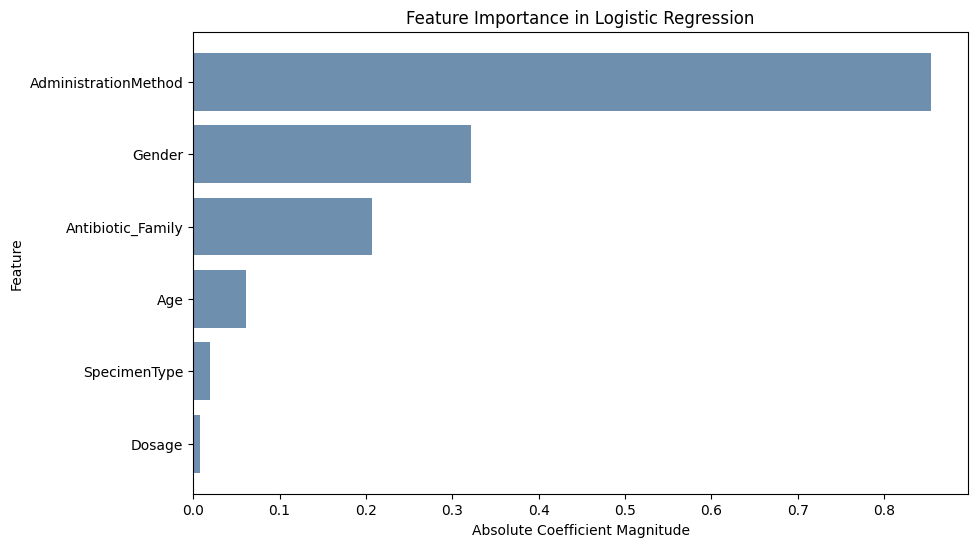

In [13]:
# Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

ROC Plot for Logisitc Reg Escherichia coli

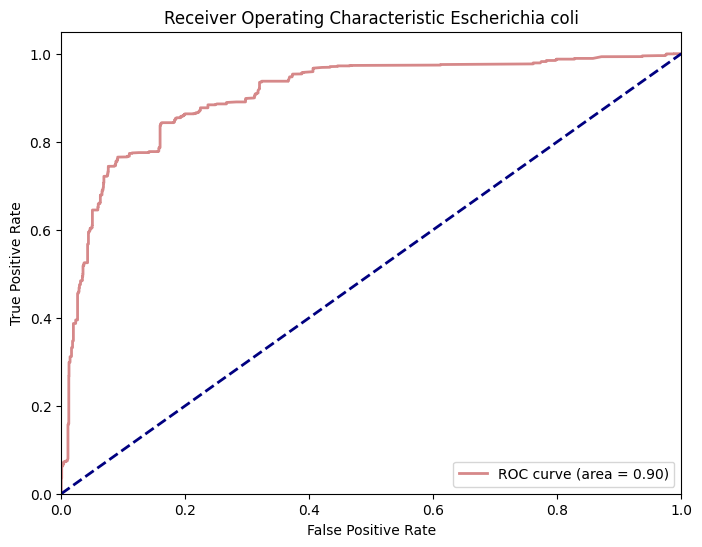

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Escherichia coli')
plt.legend(loc="lower right")
plt.show()


**Learning Curve Escherichia coli**

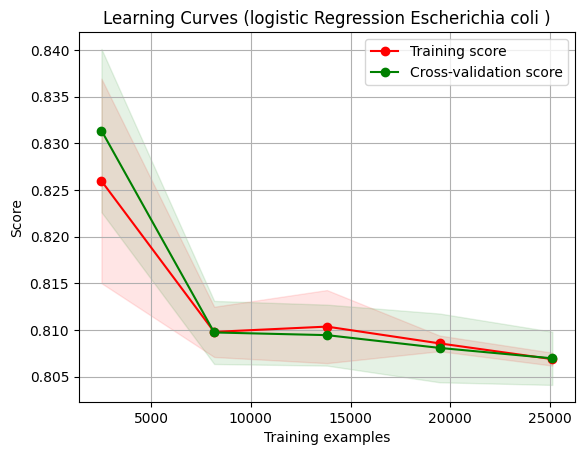

In [15]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Escherichia coli )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

#**Klebsiella pneumoniae**

In [16]:
k=data[data['Bacteria'] == 'Klebsiella pneumoniae']
df = pd.DataFrame(k)
df = df.applymap(str)


In [17]:
k.Antibiotic_Family.value_counts()

Antibiotic_Family
Glycopeptides     18347
Macrolides         6042
Cephalosporins     3711
Oxazolidinones      252
Anticoagulants       73
Penicillins          52
Name: count, dtype: int64

In [18]:
df = pd.DataFrame(k)
values_to_remove = ['Anticoagulants', 'Penicillins']
df = df[~df.isin(values_to_remove).any(axis=1)]

for col in df.columns:
    if df[col].dtype == 'object' or any(df[col].apply(lambda x: isinstance(x, int))):
        df[col] = df[col].astype(str)  # Convert column to string
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.7414918  0.7538353  0.74673721 0.75044092 0.73492063]
Mean accuracy: 0.7455
Standard deviation of scores: 0.0067
Accuracy on unseen test data: 0.7420208076177041
Confusion matrix:
 [[ 720  349]
 [1114 3488]]
Precision: 0.909043523586135
Recall: 0.7579313342025207
F1-score: 0.8266382272781135
Sensitivity: 0.7579313342025207
Specificity: 0.6735266604303087
AuROC: 0.8216953502544345
Matthews Correlation Coefficient (MCC): 0.3607489827198787


feature importantance for Klebsiella pneumoniae

Feature Importances:
Antibiotic_Family: 0.8894
Gender: -0.6461
AdministrationMethod: 0.3457
SpecimenType: 0.0902
Age: 0.0154
Dosage: -0.0104


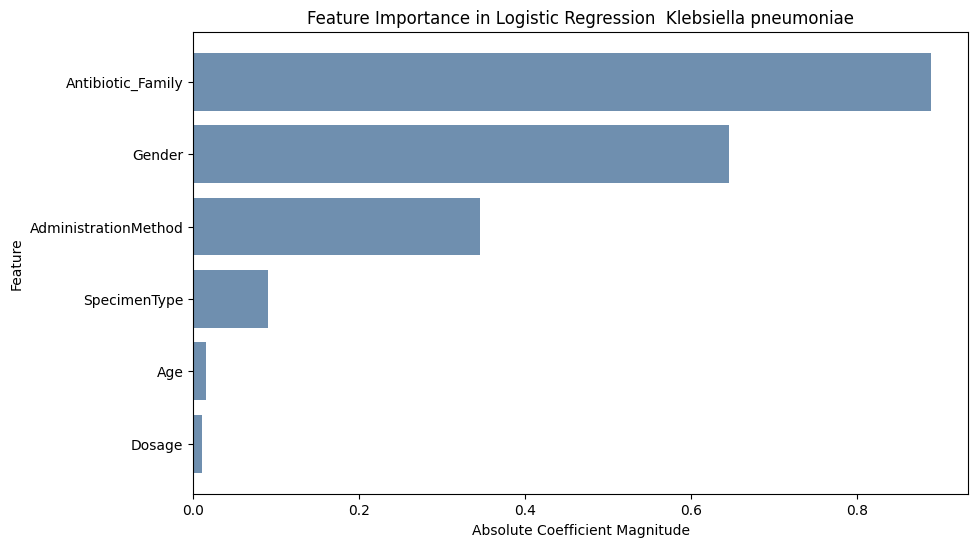

In [19]:

# Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression  Klebsiella pneumoniae')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

ROC Plot for Logisitc Reg Klebsiella pneumoiae

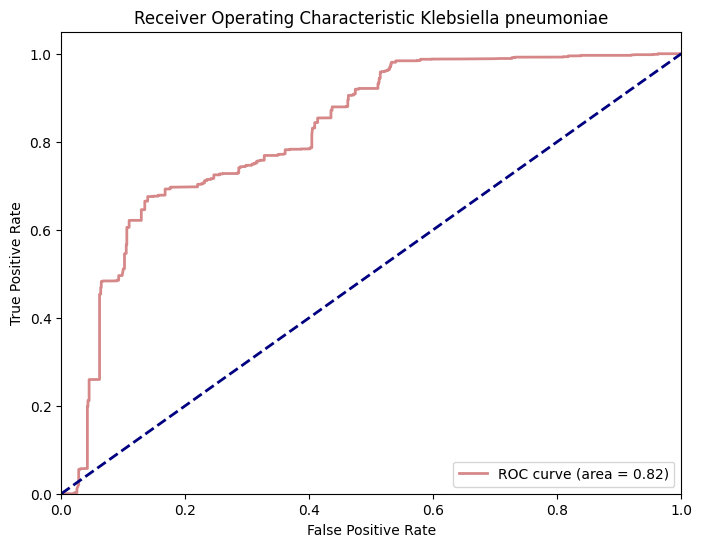

In [20]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Klebsiella pneumoniae')
plt.legend(loc="lower right")
plt.show()


**Learning Curve Klebsiella pneumoniae**

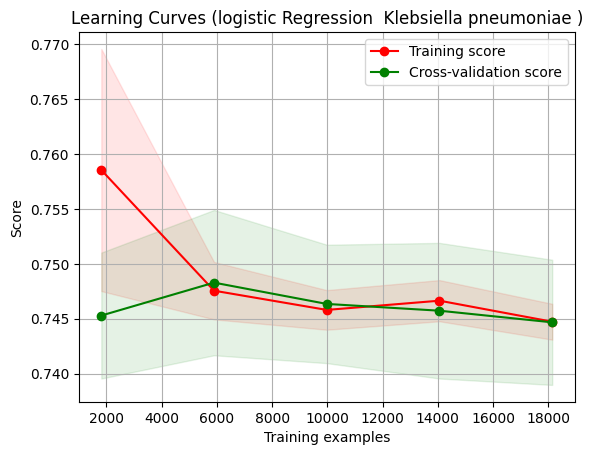

In [21]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (logistic Regression  Klebsiella pneumoniae )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

#**Pseudomonas aeruginosa**

In [22]:
pseudo=data[data['Bacteria'] == 'Pseudomonas aeruginosa']
count=pseudo.Antibiotic_Family.value_counts()
print(count)
df = pd.DataFrame(pseudo)
df = df.applymap(str)

Antibiotic_Family
Glycopeptides     10516
Cephalosporins     1872
Macrolides         1085
Oxazolidinones      114
Anticoagulants       27
Penicillins          12
Name: count, dtype: int64


In [23]:
pseudo.shape

(13626, 8)

In [24]:
values_to_remove = ['Anticoagulants', 'Penicillins','Oxazolidinones']
df = df[~df.isin(values_to_remove).any(axis=1)]

#Encode categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])
# Separate features and target
X = df.drop(columns=['SensitivityResult','Bacteria'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.55213358 0.56215213 0.5703154  0.54565702 0.57386785]
Mean accuracy: 0.5608
Standard deviation of scores: 0.0107
Accuracy on unseen test data: 0.5584415584415584
Confusion matrix:
 [[ 344  134]
 [1056 1161]]
Precision: 0.8965250965250965
Recall: 0.523680649526387
F1-score: 0.6611617312072894
Sensitivity: 0.523680649526387
Specificity: 0.7196652719665272
AuROC: 0.6797912856719568
Matthews Correlation Coefficient (MCC): 0.186046697212354


class weight code op 2 (quick fix)

In [25]:
#Encode categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])
# Separate features and target
X = df.drop(columns=['SensitivityResult', 'Bacteria'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight='balanced',max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)


Cross-validation scores: [0.55213358 0.56215213 0.5703154  0.54565702 0.57386785]
Mean accuracy: 0.5608
Standard deviation of scores: 0.0107
Accuracy on unseen test data: 0.5584415584415584
Confusion matrix:
 [[ 344  134]
 [1056 1161]]
Precision: 0.8965250965250965
Recall: 0.523680649526387
F1-score: 0.6611617312072894
Sensitivity: 0.523680649526387
Specificity: 0.7196652719665272
AuROC: 0.6797912856719568


Feature importantance for Pseudomonas aeruginosa

Feature Importances:
Gender: 1.1295
AdministrationMethod: 0.2113
Antibiotic_Family: 0.1605
Age: 0.0083
SpecimenType: 0.0041
Dosage: -0.0003


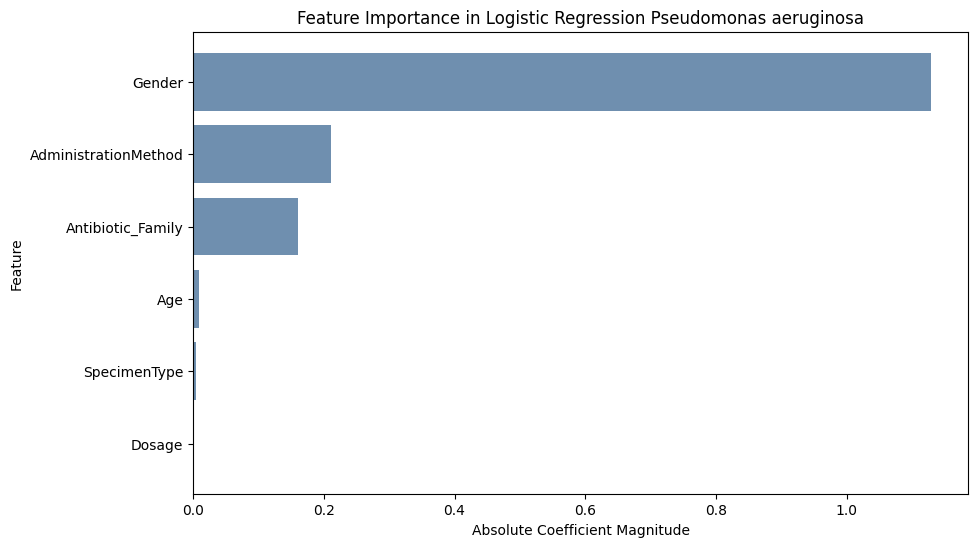

In [26]:

# Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Pseudomonas aeruginosa')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important features at the top
plt.show()

ROC Plot for Logisitc Pseudomonas aeruginosa

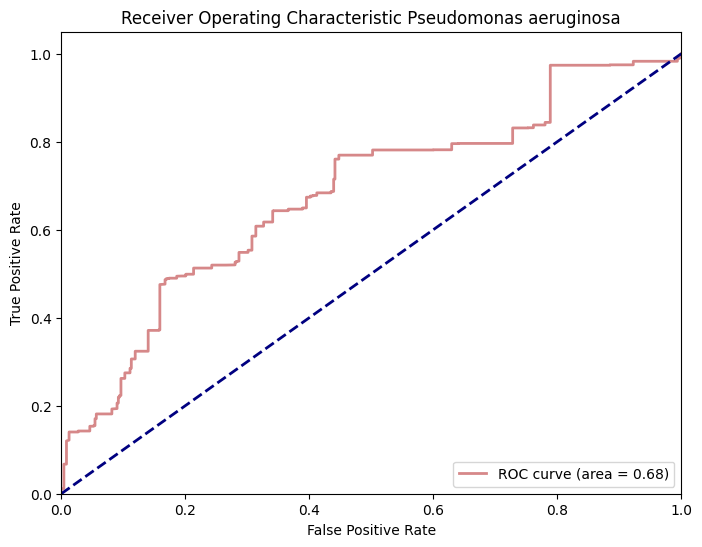

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Pseudomonas aeruginosa')
plt.legend(loc="lower right")
plt.show()


**Learning Curve Pseudomonas aeruginosa**

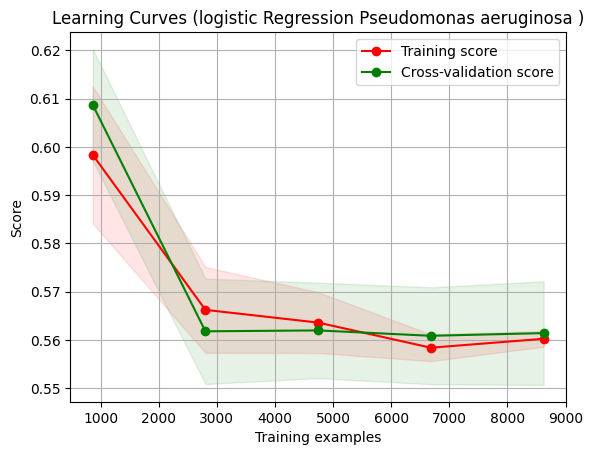

In [28]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Pseudomonas aeruginosa )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

# **Staphylococcus (coagulase-negative)**


In [29]:
staphy=data[data['Bacteria'] == 'Staphylococcus (coagulase-negative)']
s=staphy.Antibiotic_Family.value_counts()
print(s)
df = pd.DataFrame(staphy)
df = df.applymap(str)
staphy


Antibiotic_Family
Glycopeptides     7596
Macrolides        4045
Cephalosporins     907
Penicillins         16
Name: count, dtype: int64


,Age,Gender,Bacteria,SpecimenType,SensitivityResult,AdministrationMethod,Dosage,Antibiotic_Family
672,40,m,Staphylococcus (coagulase-negative),Blood,R,ORAL,1L,Penicillins
673,40,m,Staphylococcus (coagulase-negative),Blood,R,ORAL,1L,Penicillins
674,40,m,Staphylococcus (coagulase-negative),Blood,R,ORAL,1L,Penicillins
675,40,m,Staphylococcus (coagulase-negative),Blood,R,ORAL,1L,Penicillins
676,40,m,Staphylococcus (coagulase-negative),Blood,R,ORAL,1L,Penicillins
...,...,...,...,...,...,...,...,...
139403,0,m,Staphylococcus (coagulase-negative),Blood,R,INTRAVENOUS,100MG,Glycopeptides
139404,0,m,Staphylococcus (coagulase-negative),Blood,R,INTRAVENOUS,100MG,Glycopeptides
139405,0,m,Staphylococcus (coagulase-negative),Blood,R,INTRAVENOUS,100MG,Glycopeptides
139406,0,m,Staphylococcus (coagulase-negative),Blood,R,INTRAVENOUS,100MG,Glycopeptides


In [30]:
values_to_remove = ['Penicillins']
df = df[~df.isin(values_to_remove).any(axis=1)]
# Encoding categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])


# Split data into features and target
X = df.drop(columns=['SensitivityResult', 'Bacteria'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.81832669 0.84143426 0.8314741  0.83100837 0.83100837]
Mean accuracy: 0.8307
Standard deviation of scores: 0.0073
Accuracy on unseen test data: 0.8306772908366534
Confusion matrix:
 [[1521  220]
 [ 205  564]]
Precision: 0.7193877551020408
Recall: 0.7334200260078023
F1-score: 0.7263361236316808
Sensitivity: 0.7334200260078023
Specificity: 0.8736358414704193
AuROC: 0.8591791782221629
Matthews Correlation Coefficient (MCC): 0.6038273629464649


**feature importance**

Feature Importances:
Gender: -2.9135
Antibiotic_Family: -0.7205
AdministrationMethod: 0.2563
Age: 0.0442
SpecimenType: -0.0274
Dosage: 0.0004


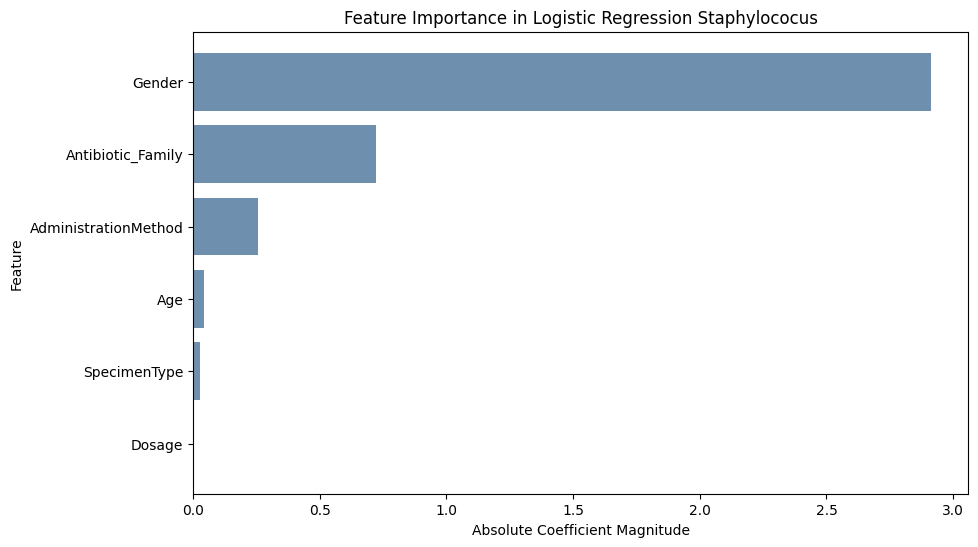

In [31]:
# Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Staphylococus')
plt.gca().invert_yaxis()
plt.show()

ROC Plot for Logistic Regression Staphylococus

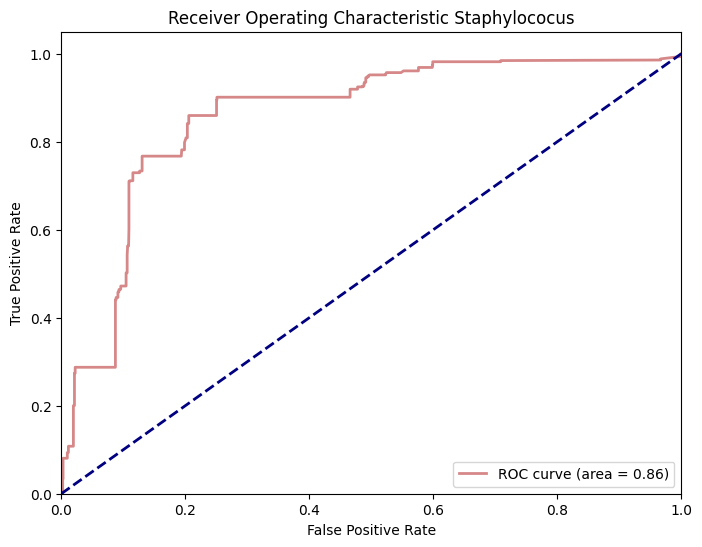

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Staphylococus')
plt.legend(loc="lower right")
plt.show()


**Learning Curve Staphylococus**

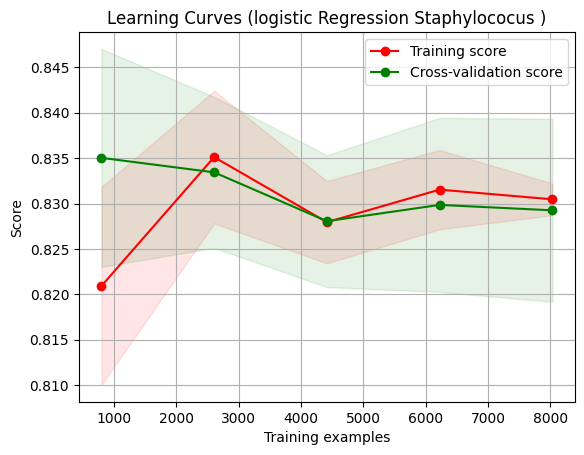

In [33]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Staphylococus )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

#**Acinetobacter baumannii**

In [34]:
acin=data[data['Bacteria'] == 'Acinetobacter baumannii']
a=acin.Antibiotic_Family.value_counts()
print(a)
df = pd.DataFrame(acin)
df = df.applymap(str)

Antibiotic_Family
Glycopeptides     9739
Cephalosporins     424
Oxazolidinones     144
Macrolides          66
Anticoagulants      39
Penicillins         17
Name: count, dtype: int64


In [35]:
values_to_remove =['Anticoagulants', 'Penicillins', 'Oxazolidinones','Marcolides']
df = df[~df.isin(values_to_remove).any(axis=1)]

# Encode categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

<ipython-input-35-b6573827d058>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
<ipython-input-35-b6573827d058>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])
<ipython-input-35-b6573827d058>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

Cross-validation scores: [0.82258065 0.83528837 0.83479961 0.8372434  0.84498778]
Mean accuracy: 0.8350
Standard deviation of scores: 0.0072
Accuracy on unseen test data: 0.8435972629521017
Confusion matrix:
 [[1563  302]
 [  18  163]]
Precision: 0.35053763440860214
Recall: 0.9005524861878453
F1-score: 0.5046439628482973
Sensitivity: 0.9005524861878453
Specificity: 0.8380697050938338
AuROC: 0.9043561980655578
Matthews Correlation Coefficient (MCC): 0.500505259554804


feature importantance

Feature Importances:
Antibiotic_Family: -1.6597
Gender: 1.3468
AdministrationMethod: 0.6771
SpecimenType: -0.1069
Age: -0.0336
Dosage: 0.0119


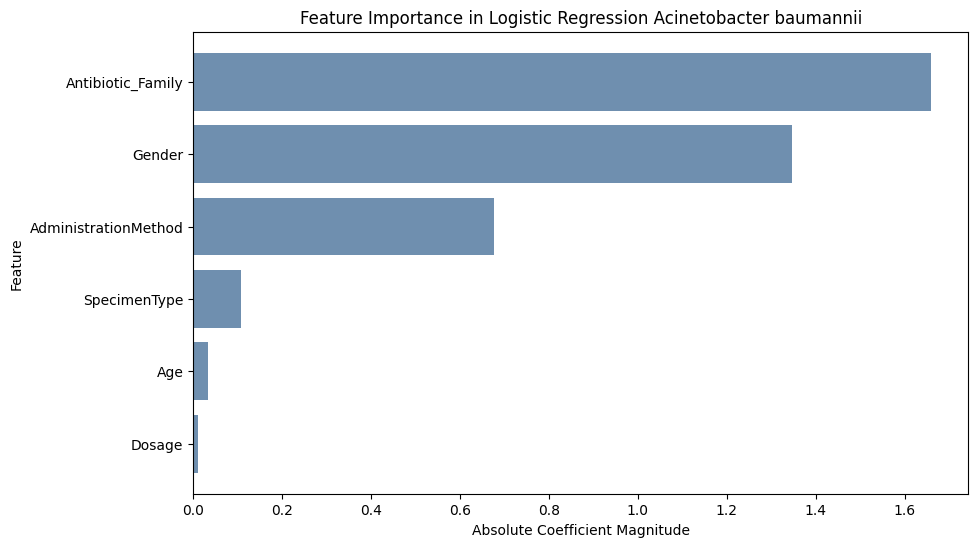

In [36]:
# Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Acinetobacter baumannii')
plt.gca().invert_yaxis()
plt.show()

ROC Plot for Logisitc Acinetobacter baumannii

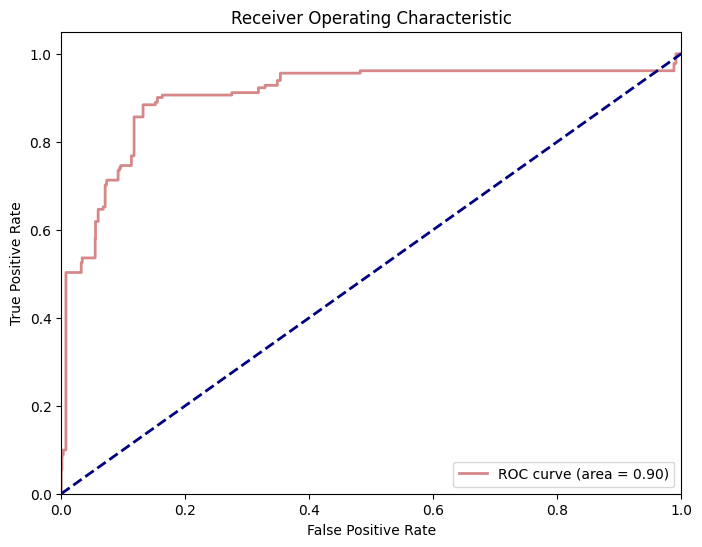

In [37]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


**Learning Curve  Acinetobacter baumannii**

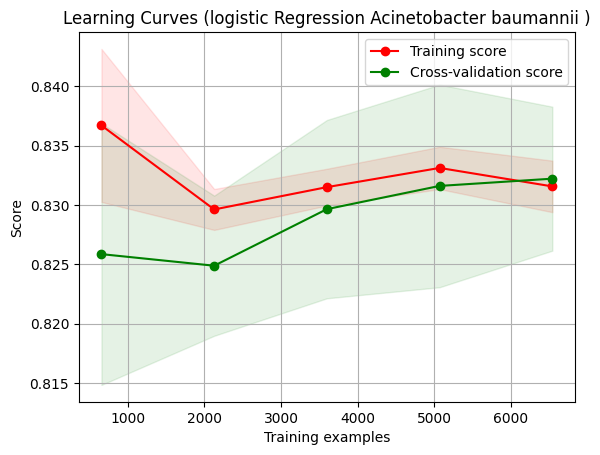

In [38]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Acinetobacter baumannii )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

#**Escherichia coli and Antibiotics**

In [124]:
df.Antibiotic_Family.value_counts()

Antibiotic_Family
0    9739
Name: count, dtype: int64

##***Escherichia coli* and *Glycopeptides***

In [125]:
eco = data[(data['Bacteria'] == 'Escherichia coli') & (data['Antibiotic_Family'] == 'Glycopeptides')]
df = pd.DataFrame(eco)
df = df.applymap(str)

In [126]:
# Encode categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.77079482 0.78049908 0.77171904 0.76039741 0.7754159 ]
Mean accuracy: 0.7718
Standard deviation of scores: 0.0066
Accuracy on unseen test data: 0.7712569316081331
Confusion matrix:
 [[ 649  107]
 [ 883 2689]]
Precision: 0.9617310443490701
Recall: 0.7527995520716685
F1-score: 0.844535175879397
Sensitivity: 0.7527995520716685
Specificity: 0.8584656084656085
AuROC: 0.8346677494563832
Matthews Correlation Coefficient (MCC): 0.48534247475467984


**Feature importance**

Feature Importances:
Gender: 0.9166
Age: 0.0571
Dosage: -0.0154
SpecimenType: 0.0122
AdministrationMethod: 0.0005


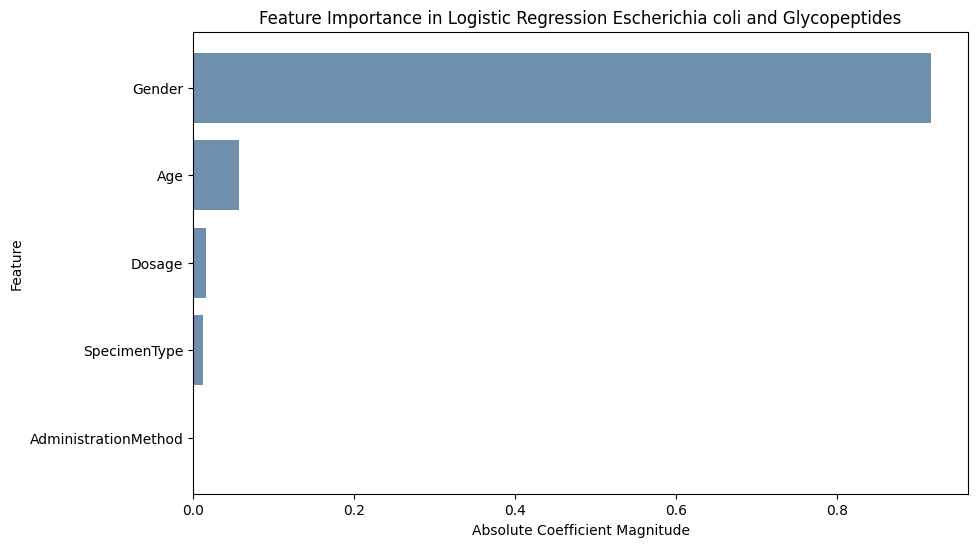

In [127]:
# Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Escherichia coli and Glycopeptides')
plt.gca().invert_yaxis()
plt.show()

 **ROC Plot**

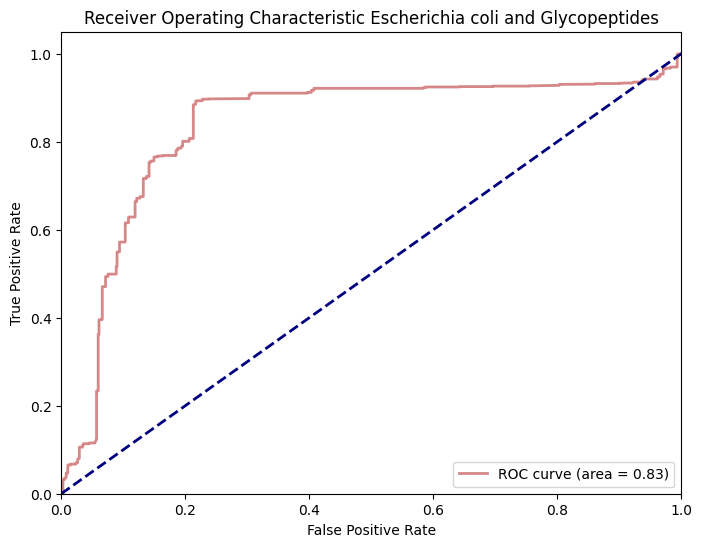

In [128]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Escherichia coli and Glycopeptides')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

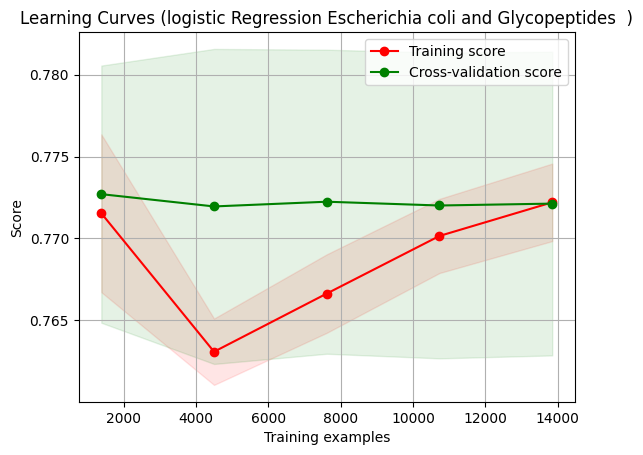

In [129]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Escherichia coli and Glycopeptides  )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

## ***Escherichia coli and Macrolides***

In [130]:
mac = data[(data['Bacteria'] == 'Escherichia coli') & (data['Antibiotic_Family'] == 'Macrolides')]
df = pd.DataFrame(mac)
df = df.applymap(str)

In [131]:
# Encode categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.83087907 0.84375    0.83125    0.83214286 0.83839286]
Mean accuracy: 0.8353
Standard deviation of scores: 0.0050
Accuracy on unseen test data: 0.8268630075858991
Confusion matrix:
 [[1580  257]
 [ 131  273]]
Precision: 0.5150943396226415
Recall: 0.6757425742574258
F1-score: 0.5845824411134903
Sensitivity: 0.6757425742574258
Specificity: 0.8600979858464889
AuROC: 0.8560253480437864
Matthews Correlation Coefficient (MCC): 0.4847500977127924


**Feature importance**

Feature Importances:
Gender: -1.3347
Age: 0.5503
SpecimenType: 0.3217
Dosage: -0.0844
AdministrationMethod: 0.0000


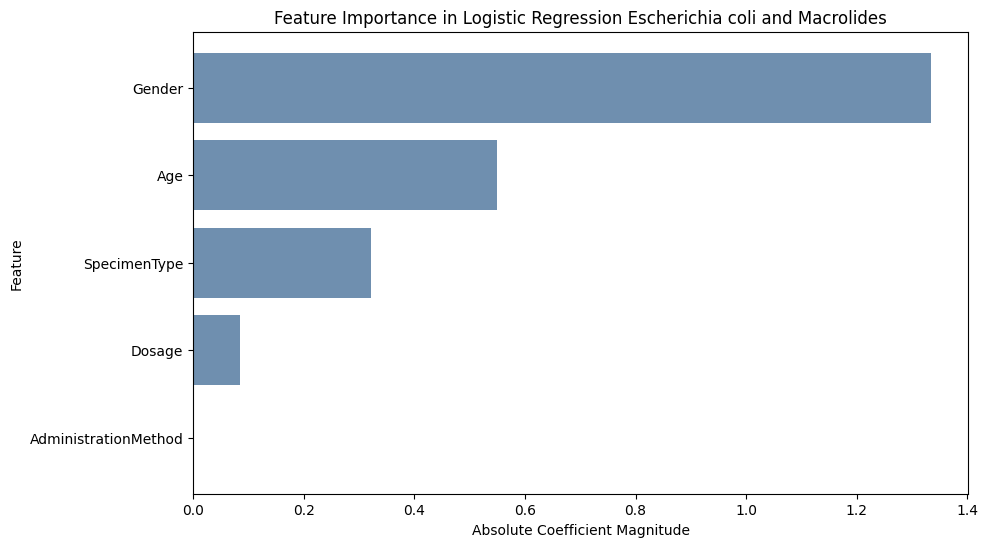

In [132]:
# Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Escherichia coli and Macrolides')
plt.gca().invert_yaxis()
plt.show()

**ROC plot**

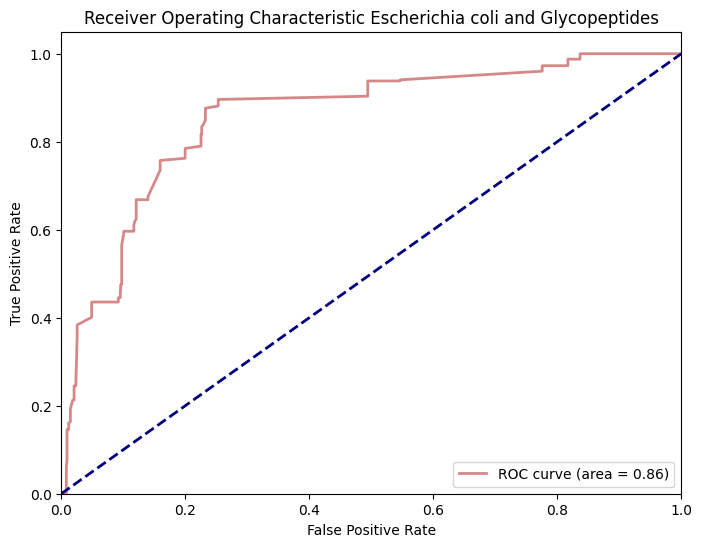

In [133]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Escherichia coli and Macrolides')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

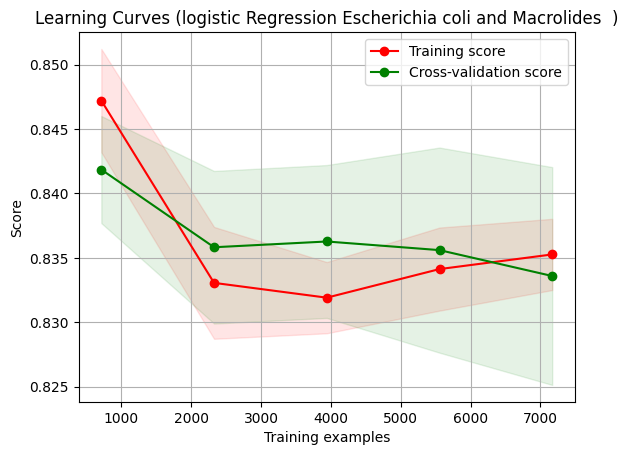

In [134]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Escherichia coli and Macrolides  )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

## ***Escherichia coli and Cephalosporins***

In [135]:
c = data[(data['Bacteria'] == 'Escherichia coli') & (data['Antibiotic_Family'] == 'Cephalosporins')]
df = pd.DataFrame(c)
df = df.applymap(str)

In [136]:
# Encode categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.80733229 0.82605304 0.79641186 0.80327869 0.81967213]
Mean accuracy: 0.8105
Standard deviation of scores: 0.0108
Accuracy on unseen test data: 0.8221528861154446
Confusion matrix:
 [[336  40]
 [188 718]]
Precision: 0.9472295514511874
Recall: 0.7924944812362031
F1-score: 0.8629807692307694
Sensitivity: 0.7924944812362031
Specificity: 0.8936170212765957
AuROC: 0.9101923934996008
Matthews Correlation Coefficient (MCC): 0.6354077026978711


**Feature Importance**

Feature Importances:
AdministrationMethod: -0.5889
Age: 0.1047
SpecimenType: 0.0971
Gender: 0.0674
Dosage: -0.0467


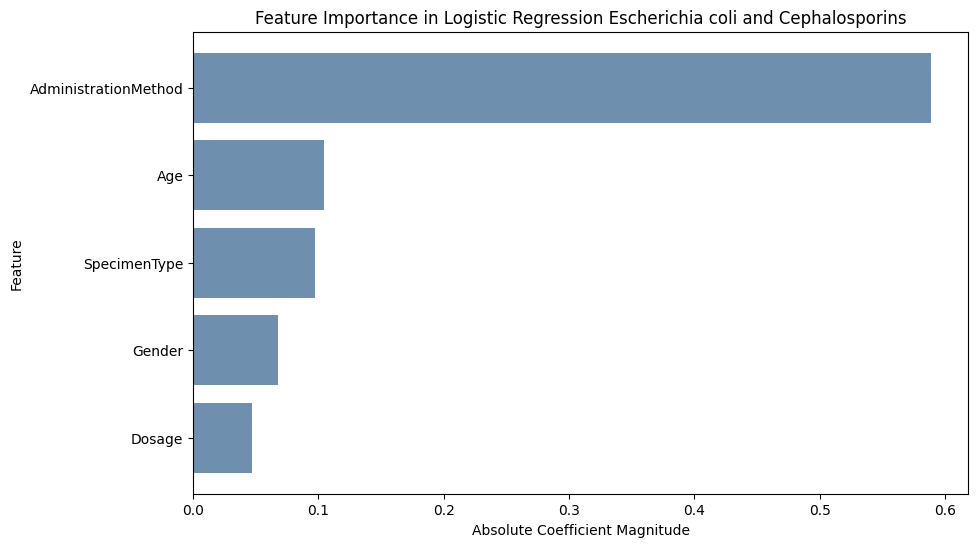

In [137]:
# Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Escherichia coli and Cephalosporins')
plt.gca().invert_yaxis()
plt.show()

**ROC Plot**

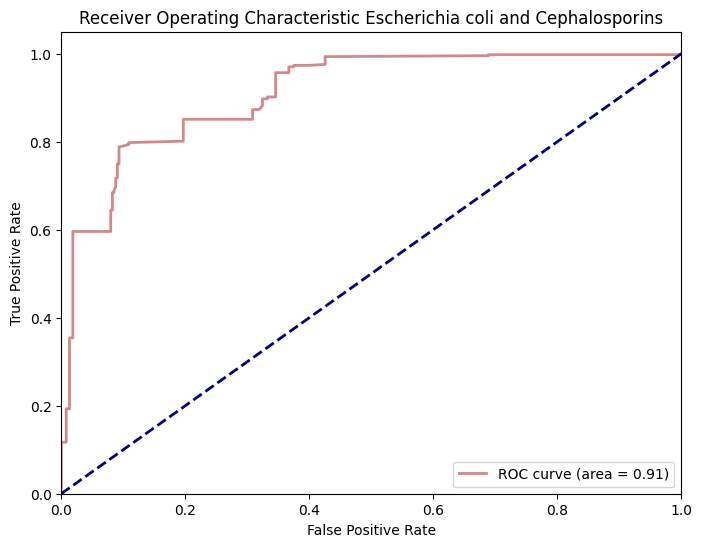

In [138]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Escherichia coli and Cephalosporins')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

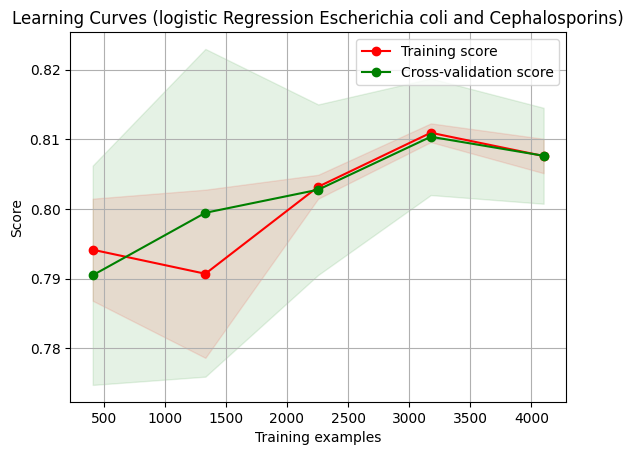

In [139]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Escherichia coli and Cephalosporins)"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

#**Klebsiella pneumoniae and Antibiotics**

In [45]:
kly=data[data['Bacteria']=='Klebsiella pneumoniae']
kly.Antibiotic_Family.value_counts()

Antibiotic_Family
Glycopeptides     18347
Macrolides         6042
Cephalosporins     3711
Oxazolidinones      252
Anticoagulants       73
Penicillins          52
Name: count, dtype: int64

## ***Klebsiella pneumoniae and Glycopeptides***

In [46]:
kd=data[(data['Bacteria']=='Klebsiella pneumoniae') & (data['Antibiotic_Family'] =='Glycopeptides')]
df = pd.DataFrame(kd)
df= df.applymap(str)

In [47]:
# Encode categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.7613079  0.7493188  0.75851731 0.75170346 0.75279368]
Mean accuracy: 0.7547
Standard deviation of scores: 0.0045
Accuracy on unseen test data: 0.7591280653950954
Confusion matrix:
 [[ 574  245]
 [ 639 2212]]
Precision: 0.9002849002849003
Recall: 0.7758681164503682
F1-score: 0.8334589299171062
Sensitivity: 0.7758681164503682
Specificity: 0.7008547008547008
AuROC: 0.8679667695802387
Matthews Correlation Coefficient (MCC): 0.4219621726889805


**Feature Importance**

Feature Importances:
Gender: -0.7053
AdministrationMethod: 0.3423
SpecimenType: 0.1083
Dosage: -0.0230
Age: 0.0221


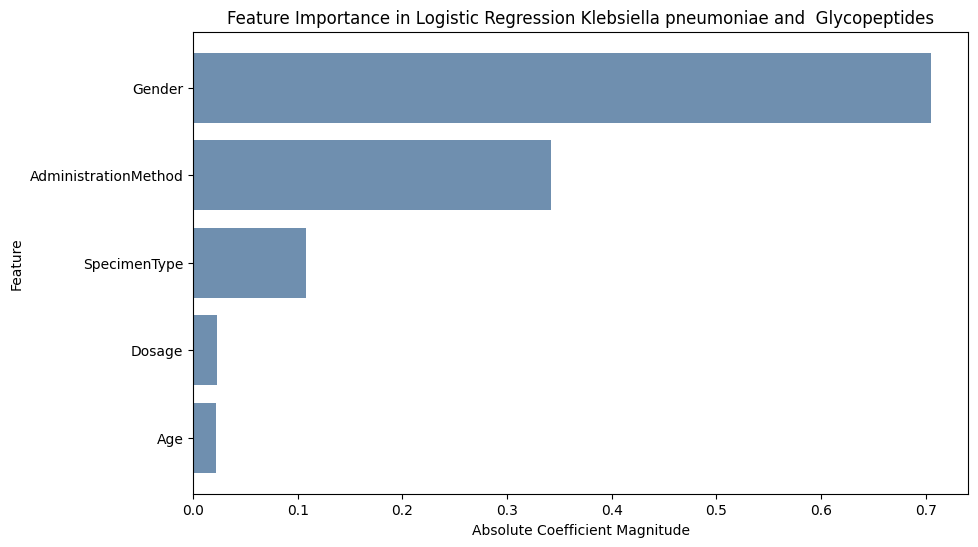

In [48]:
#Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Klebsiella pneumoniae and  Glycopeptides')
plt.gca().invert_yaxis()
plt.show()

**ROC Plot**

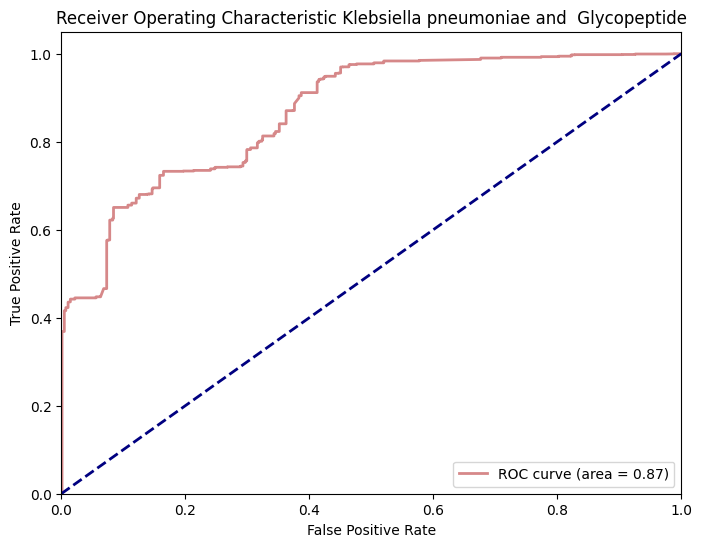

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Klebsiella pneumoniae and  Glycopeptide')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

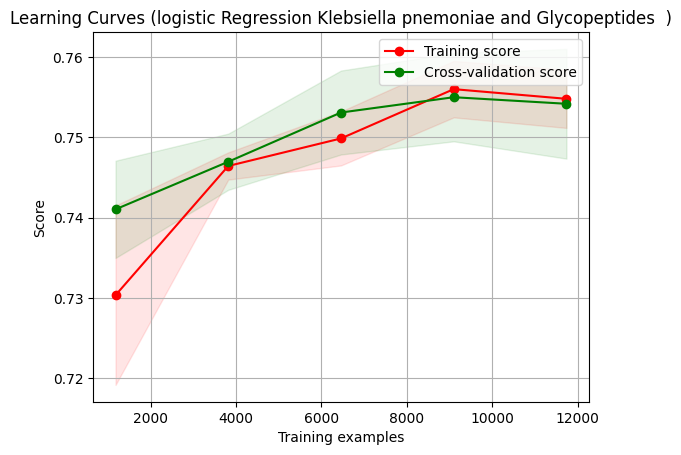

In [50]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Klebsiella pnemoniae and Glycopeptides  )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

## ***Klebsiella pneumoniae and Cephalosporins***

In [70]:
kc=data[(data['Bacteria']=='Klebsiella pneumoniae') & (data['Antibiotic_Family'] =='Cephalosporins')]
df = pd.DataFrame(kc)
df= df.applymap(str)

In [71]:
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

model.fit(X_train, y_train)

test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

test_predictions = model.predict(X_test)

conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.72543742 0.6509434  0.70619946 0.65768194 0.71832884]
Mean accuracy: 0.6917
Standard deviation of scores: 0.0312
Accuracy on unseen test data: 0.7402422611036339
Confusion matrix:
 [[113  54]
 [139 437]]
Precision: 0.890020366598778
Recall: 0.7586805555555556
F1-score: 0.8191190253045924
Sensitivity: 0.7586805555555556
Specificity: 0.6766467065868264
AuROC: 0.7577761144377912
Matthews Correlation Coefficient (MCC): 0.3838347816572917


**Feature Importance**

In [ ]:
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Klebsiella pneumoniae and  Cephalosporins')
plt.gca().invert_yaxis()
plt.show()

**ROC Plot**

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Klebsiella pneumoniae and  Cephalosporins')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Escherichia coli and Cephalosporins)"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

## ***Klebsiella pneumoniae and Macrolides***

In [72]:
km=data[(data['Bacteria']=='Klebsiella pneumoniae') & (data['Antibiotic_Family'] =='Macrolides')]
df = pd.DataFrame(km)
df= df.applymap(str)

In [73]:
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

model.fit(X_train, y_train)

test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

test_predictions = model.predict(X_test)

conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.92969396 0.93382961 0.91970199 0.93129139 0.9205298 ]
Mean accuracy: 0.9270
Standard deviation of scores: 0.0058
Accuracy on unseen test data: 0.923904052936311
Confusion matrix:
 [[  76    6]
 [  86 1041]]
Precision: 0.994269340974212
Recall: 0.9236912156166814
F1-score: 0.9576816927322908
Sensitivity: 0.9236912156166814
Specificity: 0.926829268292683
AuROC: 0.9566353582790487
Matthews Correlation Coefficient (MCC): 0.6278021717448297


**Feature Importance**

Feature Importances:
Gender: 0.9465
SpecimenType: 0.7746
Age: -0.7118
Dosage: 0.4411
AdministrationMethod: 0.0000


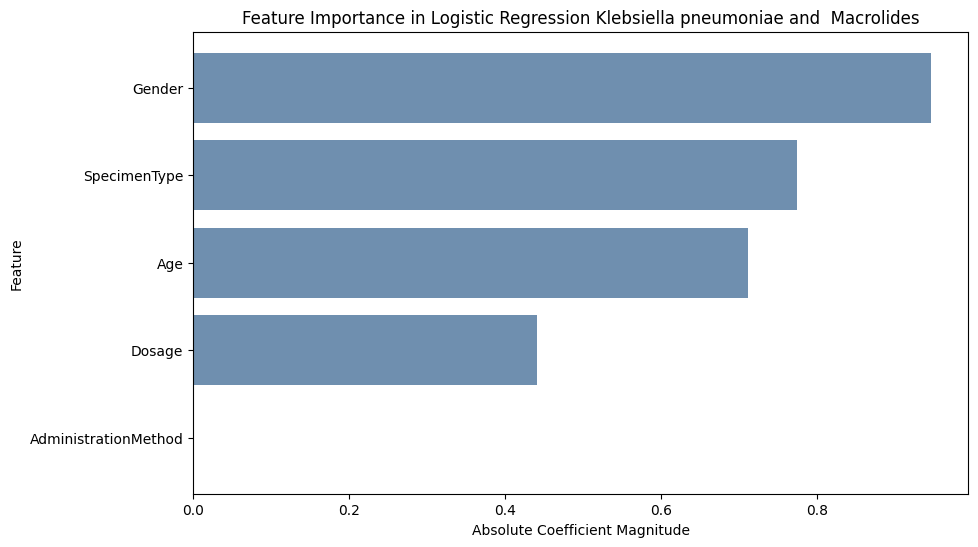

In [74]:
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Klebsiella pneumoniae and  Macrolides')
plt.gca().invert_yaxis()
plt.show()

**ROC Plot**

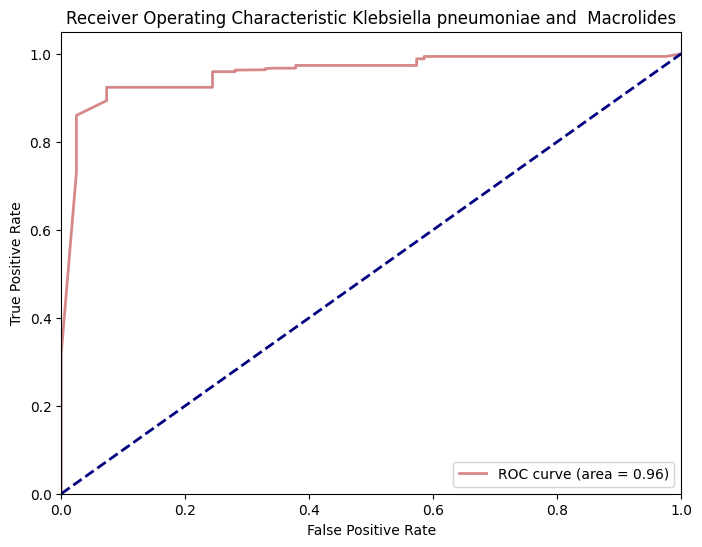

In [75]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Klebsiella pneumoniae and  Macrolides')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

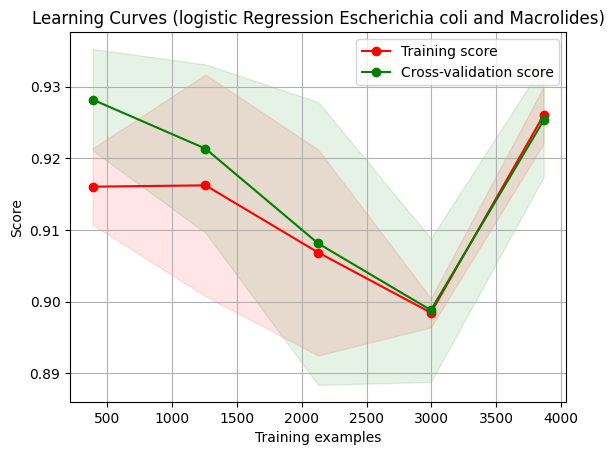

In [76]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Escherichia coli and Macrolides)"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

#**Pseudomonas aeruginosa and Antibiotics**

In [123]:
p=data[(data['Bacteria']=='Pseudomonas aeruginosa') ]
p.Antibiotic_Family.value_counts()


Antibiotic_Family
Glycopeptides     10516
Cephalosporins     1872
Macrolides         1085
Oxazolidinones      114
Anticoagulants       27
Penicillins          12
Name: count, dtype: int64

## ***Pseudomonas aeruginosa* and *Glycopeptides***

In [82]:
pg=data[(data['Bacteria']=='Pseudomonas aeruginosa') & (data['Antibiotic_Family'] =='Glycopeptides')]
df = pd.DataFrame(pg)
df= df.applymap(str)

In [83]:
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

model.fit(X_train, y_train)

test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

test_predictions = model.predict(X_test)


conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.62452471 0.62196862 0.60675226 0.62196862 0.61436044]
Mean accuracy: 0.6179
Standard deviation of scores: 0.0065
Accuracy on unseen test data: 0.6116920152091255
Confusion matrix:
 [[ 267  100]
 [ 717 1020]]
Precision: 0.9107142857142857
Recall: 0.5872193436960277
F1-score: 0.7140357017850893
Sensitivity: 0.5872193436960277
Specificity: 0.7275204359673024
AuROC: 0.6673341396344037
Matthews Correlation Coefficient (MCC): 0.23937457335163803


**Feature Importance**

Feature Importances:
Gender: 0.7548
AdministrationMethod: -0.0914
SpecimenType: -0.0278
Age: 0.0075
Dosage: 0.0009


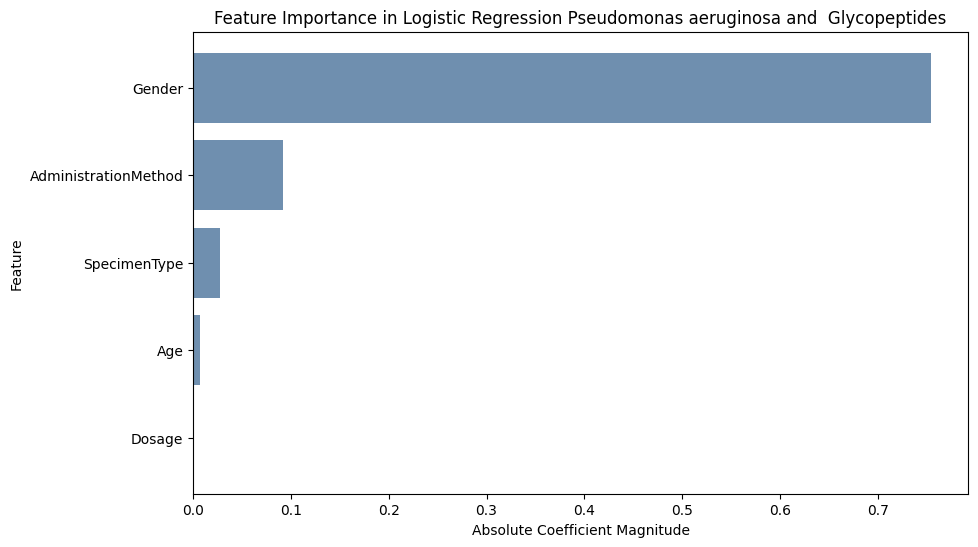

In [53]:
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Pseudomonas aeruginosa and  Glycopeptides')
plt.gca().invert_yaxis()
plt.show()

**ROC Plot**

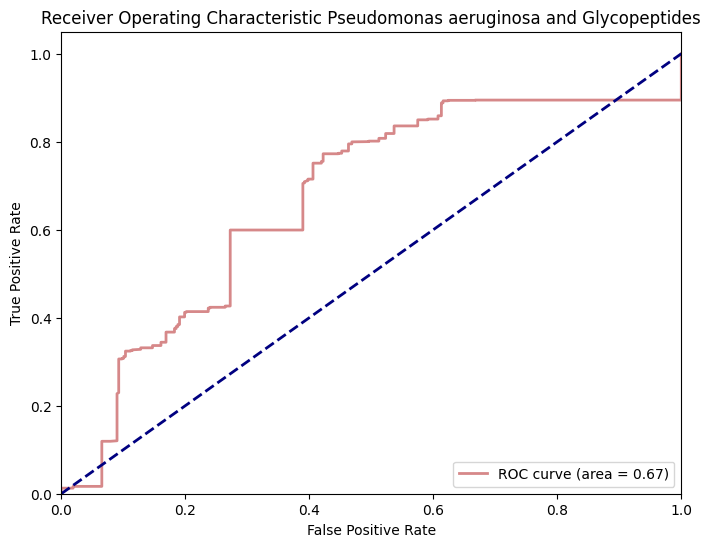

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Pseudomonas aeruginosa and Glycopeptides')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

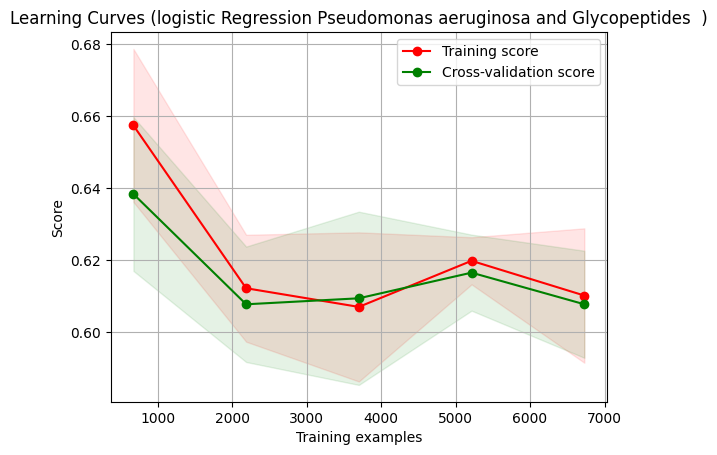

In [55]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Pseudomonas aeruginosa and Glycopeptides  )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

## ***Pseudomonas aeruginosa* and *Cephalosporins***

In [90]:
pc=data[(data['Bacteria']=='Pseudomonas aeruginosa') & (data['Antibiotic_Family'] =='Cephalosporins')]
df = pd.DataFrame(pc)
df= df.applymap(str)

In [91]:
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

model.fit(X_train, y_train)

test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

test_predictions = model.predict(X_test)


conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.808      0.82133333 0.80481283 0.8315508  0.86363636]
Mean accuracy: 0.8259
Standard deviation of scores: 0.0212
Accuracy on unseen test data: 0.8426666666666667
Confusion matrix:
 [[ 74  10]
 [ 49 242]]
Precision: 0.9603174603174603
Recall: 0.8316151202749141
F1-score: 0.8913443830570902
Sensitivity: 0.8316151202749141
Specificity: 0.8809523809523809
AuROC: 0.8939207985599739
Matthews Correlation Coefficient (MCC): 0.6327895850406324


**Feature Importance**

Feature Importances:
Gender: 1.7525
Dosage: -0.4640
AdministrationMethod: 0.4249
SpecimenType: 0.4066
Age: 0.0661


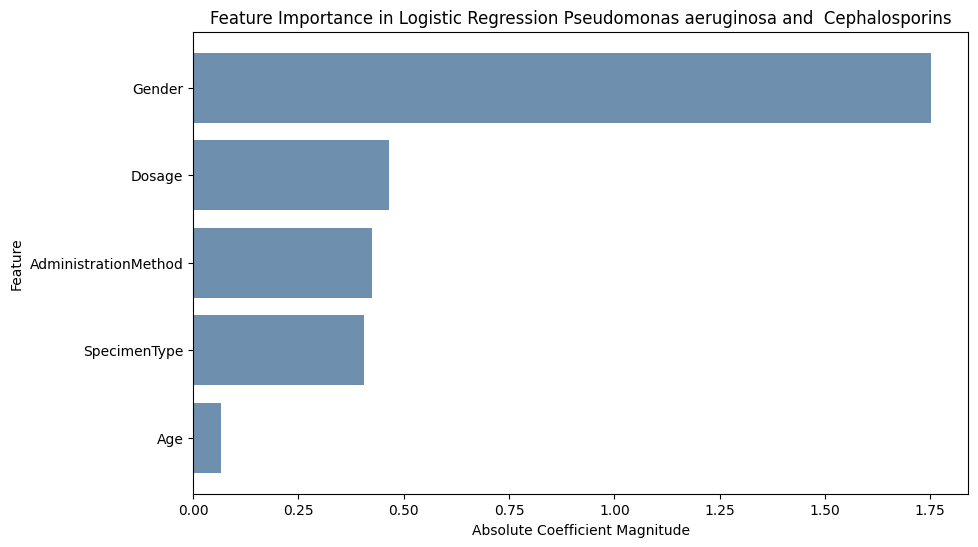

In [92]:
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Pseudomonas aeruginosa and  Cephalosporins')
plt.gca().invert_yaxis()
plt.show()

**ROC Plot**

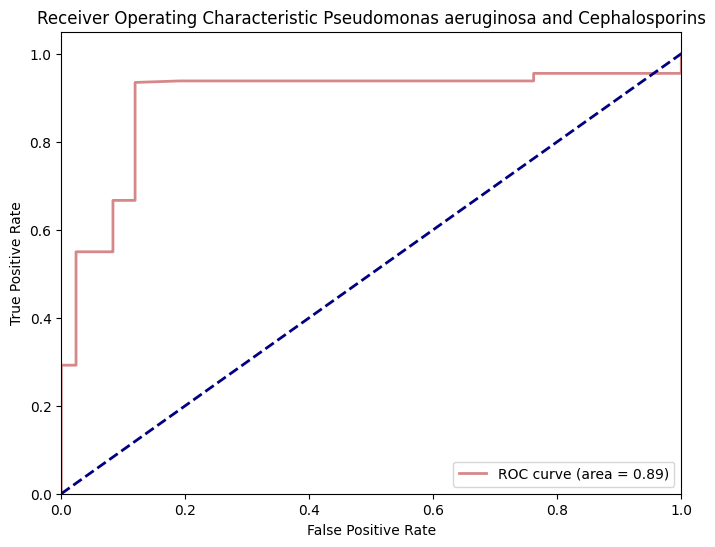

In [93]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Pseudomonas aeruginosa and Cephalosporins')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

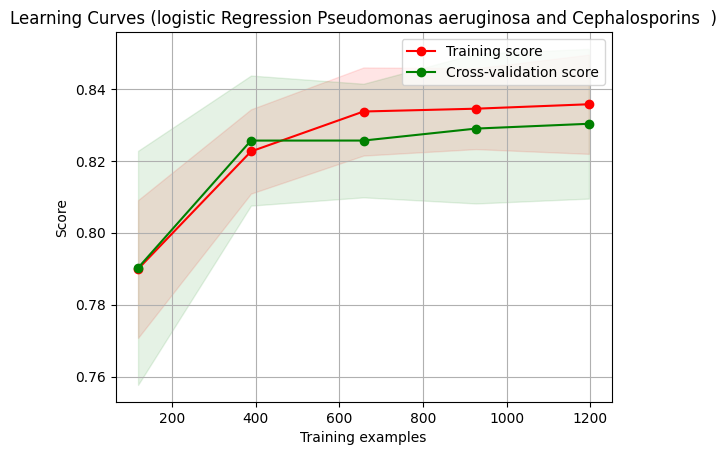

In [94]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Pseudomonas aeruginosa and Cephalosporins  )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

#**Staphylococcus (coagulase-negative) and Antibiotics**

In [99]:
st=data[(data['Bacteria']=='Staphylococcus (coagulase-negative)') ]
st.Antibiotic_Family.value_counts()

Antibiotic_Family
Glycopeptides     7596
Macrolides        4045
Cephalosporins     907
Penicillins         16
Name: count, dtype: int64

## ***Staphylococcus (coagulase-negative)* and *Glycopeptides***

In [100]:
sg=data[(data['Bacteria']=='Staphylococcus (coagulase-negative)') & (data['Antibiotic_Family'] =='Glycopeptides')]
df = pd.DataFrame(sg)
df= df.applymap(str)

In [101]:
# Encode categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.78355263 0.77616853 0.7965767  0.77946017 0.79591837]
Mean accuracy: 0.7863
Standard deviation of scores: 0.0084
Accuracy on unseen test data: 0.7881578947368421
Confusion matrix:
 [[781 170]
 [152 417]]
Precision: 0.7103918228279387
Recall: 0.7328646748681898
F1-score: 0.7214532871972318
Sensitivity: 0.7328646748681898
Specificity: 0.8212407991587802
AuROC: 0.8110323237587296
Matthews Correlation Coefficient (MCC): 0.5507810121031852


**Feature Importance**

Feature Importances:
Gender: -2.5243
AdministrationMethod: -0.1162
Age: 0.0204
Dosage: -0.0125
SpecimenType: -0.0111


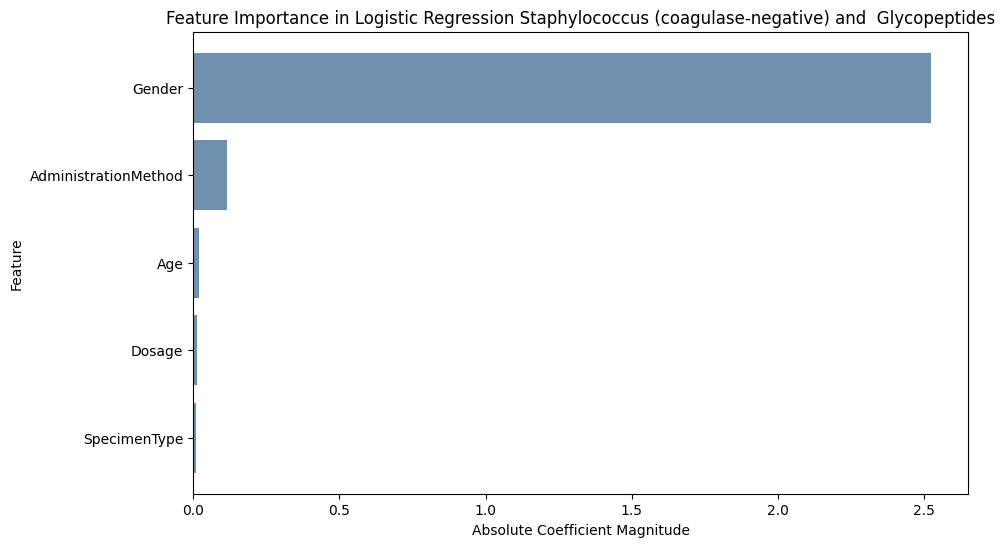

In [102]:
#Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Staphylococcus (coagulase-negative) and  Glycopeptides')
plt.gca().invert_yaxis()
plt.show()

**ROC Plot**

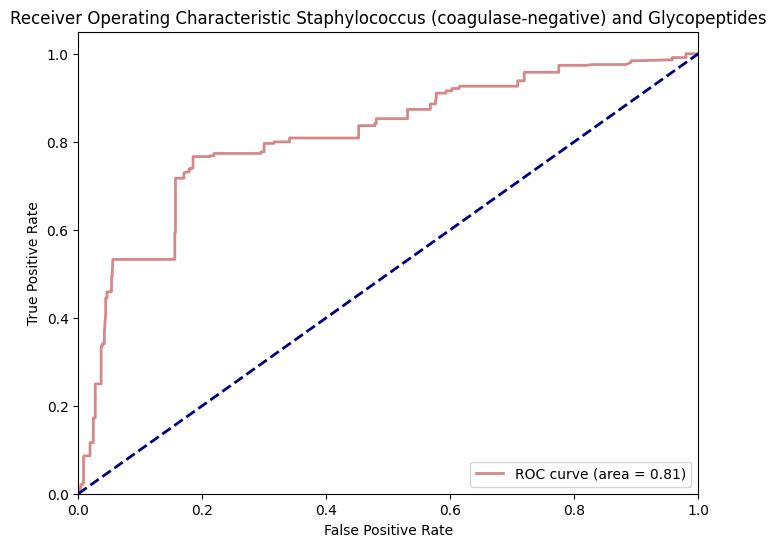

In [103]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Staphylococcus (coagulase-negative) and Glycopeptides')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

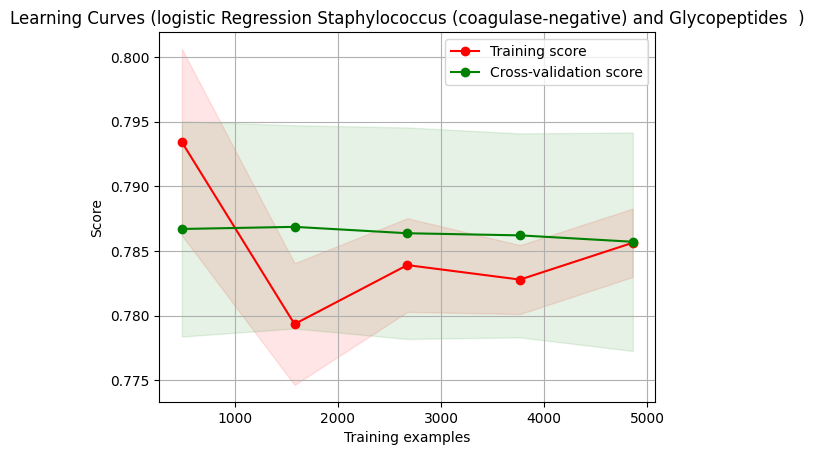

In [104]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Staphylococcus (coagulase-negative) and Glycopeptides  )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

## ***Staphylococcus (coagulase-negative)* and *Macrolides***

In [105]:
sm=data[(data['Bacteria']=='Staphylococcus (coagulase-negative)') & (data['Antibiotic_Family'] =='Macrolides')]
df = pd.DataFrame(sm)
df= df.applymap(str)

In [106]:
# Encode categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.9802225  0.97527812 0.98516687 0.97651422 0.97775031]
Mean accuracy: 0.9790
Standard deviation of scores: 0.0035
Accuracy on unseen test data: 0.9789864029666254
Confusion matrix:
 [[670   7]
 [ 10 122]]
Precision: 0.9457364341085271
Recall: 0.9242424242424242
F1-score: 0.9348659003831418
Sensitivity: 0.9242424242424242
Specificity: 0.9896602658788775
AuROC: 0.9745199409158051
Matthews Correlation Coefficient (MCC): 0.922426867472186


**Feature Importance**

Feature Importances:
Gender: -7.3807
Age: 2.2866
SpecimenType: -0.7567
Dosage: -0.2546
AdministrationMethod: 0.0000


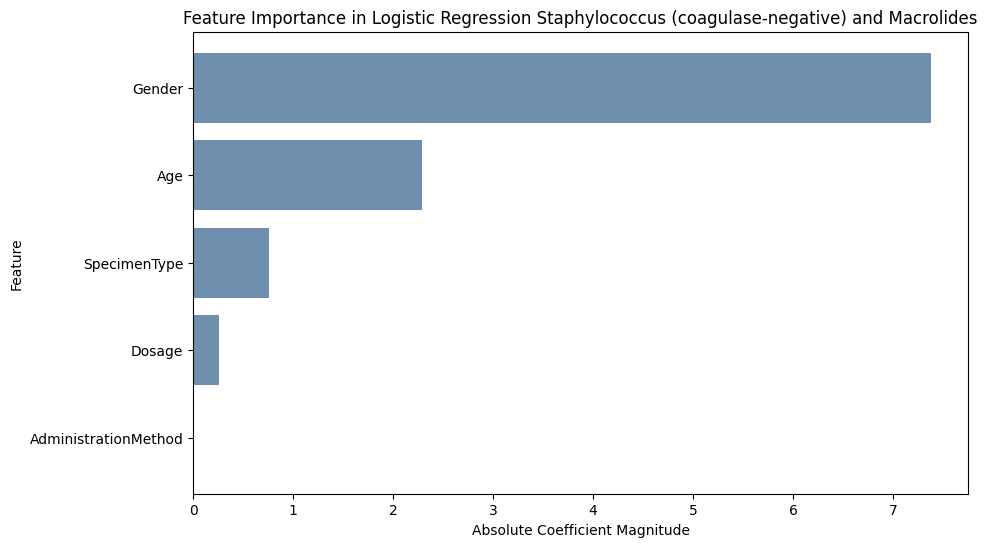

In [107]:
#Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Staphylococcus (coagulase-negative) and Macrolides')
plt.gca().invert_yaxis()
plt.show()

**ROC Plot**

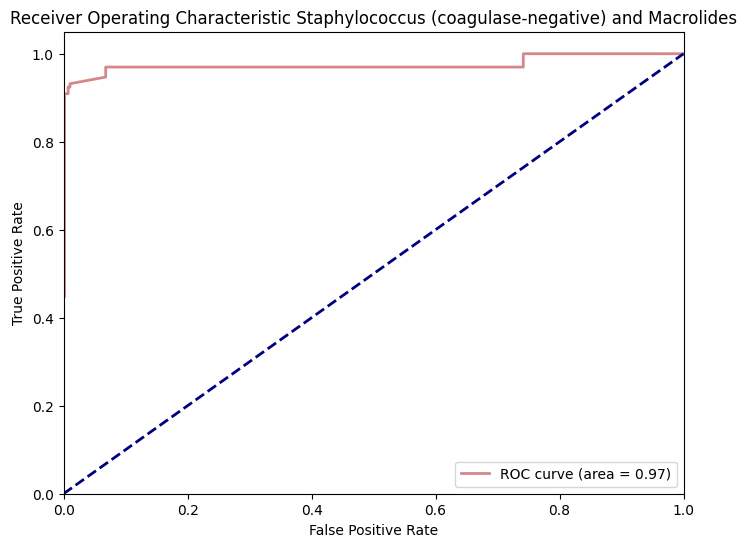

In [108]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Staphylococcus (coagulase-negative) and Macrolides')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

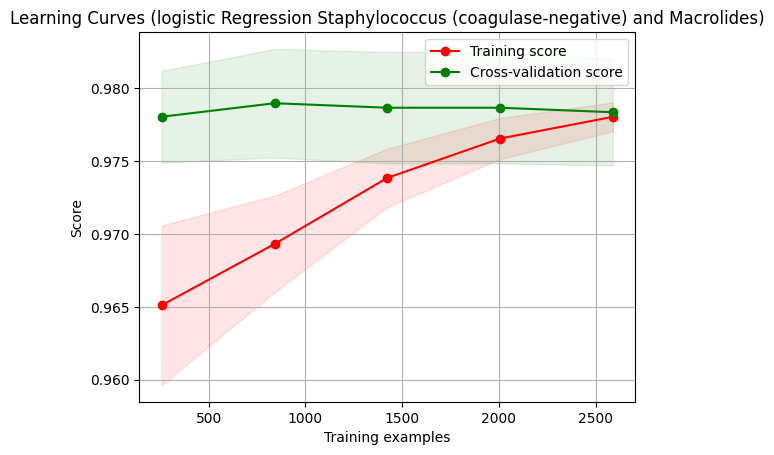

In [109]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Staphylococcus (coagulase-negative) and Macrolides)"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()

#**Acinetobacter baumannii and Antibiotics**

In [115]:
a=data[(data['Bacteria']=='Acinetobacter baumannii') ]
a.Antibiotic_Family.value_counts()

Antibiotic_Family
Glycopeptides     9739
Cephalosporins     424
Oxazolidinones     144
Macrolides          66
Anticoagulants      39
Penicillins         17
Name: count, dtype: int64

## ***Acinetobacter baumannii* and *Glycopeptidess***

In [140]:
ag=data[(data['Bacteria']=='Acinetobacter baumannii') & (data['Antibiotic_Family'] =='Glycopeptides')]
df = pd.DataFrame(ag)
df= df.applymap(str)

In [141]:
# Encode categorical data
for col in df.columns:
    if df[col].dtype == 'object':
        label_encoder = LabelEncoder()
        df[col] = label_encoder.fit_transform(df[col])

X = df.drop(columns=['SensitivityResult','Bacteria','Antibiotic_Family'])
y = df['SensitivityResult']

model = LogisticRegression(class_weight="balanced",max_iter=1000)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Perform cross-validation on the scaled and resampled training data
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=stratified_kfold, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean accuracy: {:.4f}".format(cv_scores.mean()))
print("Standard deviation of scores: {:.4f}".format(cv_scores.std()))

# Fit the model on the full training set
model.fit(X_train, y_train)

# Evaluate the trained model on the test set
test_accuracy = model.score(X_test, y_test)
print("Accuracy on unseen test data:", test_accuracy)

# Make predictions on the test set
test_predictions = model.predict(X_test)


# Calculate confusion matrix
conf_matrix_test = confusion_matrix(y_test, test_predictions)
print("Confusion matrix:\n", conf_matrix_test)

# Calculate sensitivity and specificity
tn_test, fp_test, fn_test, tp_test = conf_matrix_test.ravel()
sensitivity_test = tp_test / (tp_test + fn_test)
specificity_test = tn_test / (tn_test + fp_test)

# Calculate precision, recall, and F1-score based on test set predictions
precision_test = precision_score(y_test, test_predictions)
recall_test = recall_score(y_test, test_predictions)
f1_score_test = f1_score(y_test, test_predictions)

# Calculate AuROC based on test set predictions
test_predictions_proba = model.predict_proba(X_test)[:, 1]
auc_roc_test = roc_auc_score(y_test, test_predictions_proba)

# Print the metrics based on test set predictions
print("Precision:", precision_test)
print("Recall:", recall_test)
print("F1-score:", f1_score_test)
print("Sensitivity:", sensitivity_test)
print("Specificity:", specificity_test)
print("AuROC:", auc_roc_test)
mcc = matthews_corrcoef(y_test, test_predictions)
print("Matthews Correlation Coefficient (MCC):", mcc)

Cross-validation scores: [0.82546201 0.85061602 0.84548255 0.83829569 0.83204931]
Mean accuracy: 0.8384
Standard deviation of scores: 0.0090
Accuracy on unseen test data: 0.8495893223819302
Confusion matrix:
 [[1529  272]
 [  21  126]]
Precision: 0.3165829145728643
Recall: 0.8571428571428571
F1-score: 0.46238532110091735
Sensitivity: 0.8571428571428571
Specificity: 0.8489727928928373
AuROC: 0.898548425477909
Matthews Correlation Coefficient (MCC): 0.4625769366840925


**Feature Importance**

Feature Importances:
Gender: 1.0337
SpecimenType: -0.1010
Age: -0.0570
AdministrationMethod: 0.0300
Dosage: 0.0111


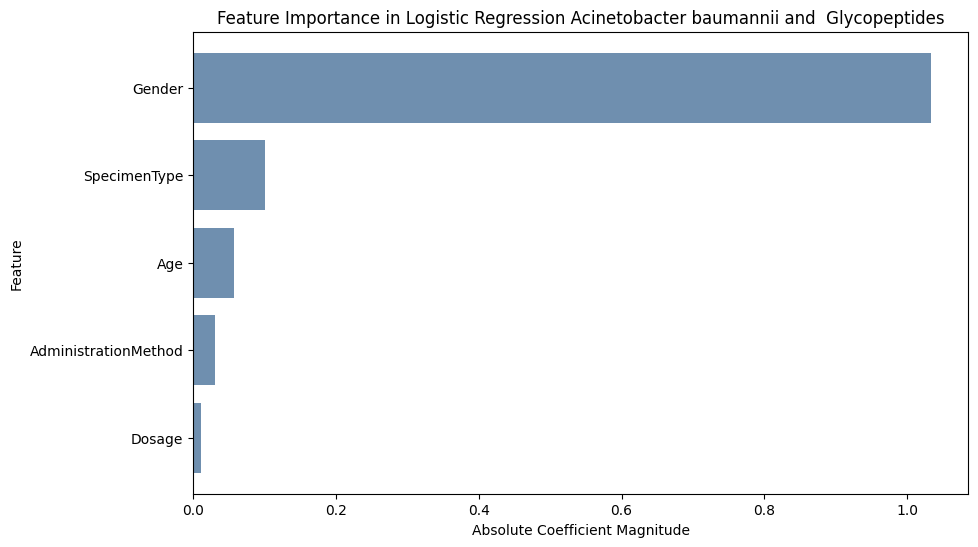

In [118]:
#Get the model's coefficients
coefficients = model.coef_[0]
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Importance': abs(coefficients)  # Absolute value to assess impact
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_importance_df['Feature'], feature_importance_df['Coefficient']):
    print(f"{feature}: {importance:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#6F8FAF')
plt.xlabel('Absolute Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Feature Importance in Logistic Regression Acinetobacter baumannii and  Glycopeptides')
plt.gca().invert_yaxis()
plt.show()

**ROC Plot**

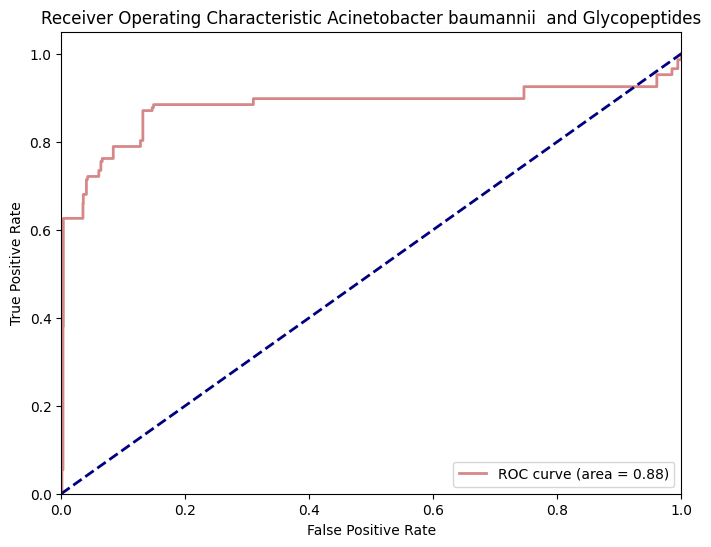

In [119]:
fpr, tpr, thresholds = roc_curve(y_test, test_predictions_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color=colorPalette[2], lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Acinetobacter baumannii  and Glycopeptides')
plt.legend(loc="lower right")
plt.show()


**Learning Curve**

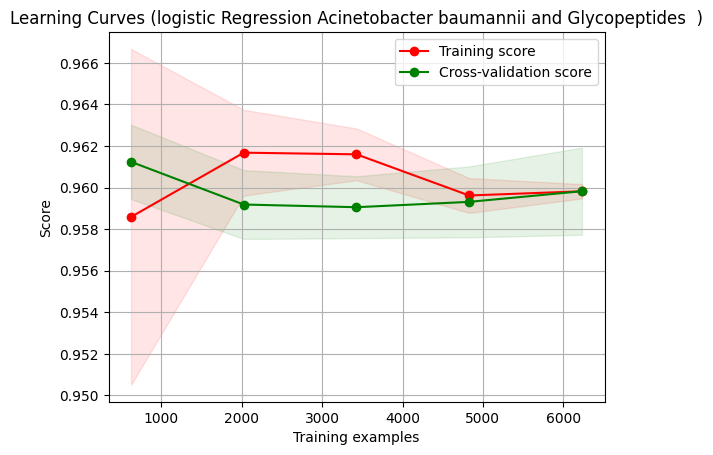

In [120]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Plot learning curves
title = "Learning Curves (logistic Regression Acinetobacter baumannii and Glycopeptides  )"
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(model, title, X_train, y_train, cv=cv, n_jobs=-1)

plt.show()